# python DB connect

mysql 데이터 베이스에 테이블을 만들고 python 코드를 이용해서 데이터를 써보겠습니다. 
이를 통해서 코드를 이용해서 데이터를 다루는 법을 익혀보겠습니다.

## DB 테이블 만들기

먼저 mysql workbench를 열어주고, 타이타닉 데이터 셋을 저장하기 위한 테이블을 만들어주겠습니다.

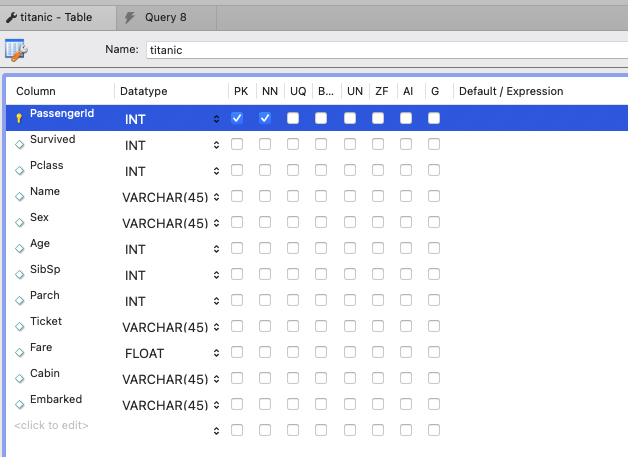

## python 코드로 mysql 접속하기

python 코드에서 mysql을 접속하기 위해서는 pymysql 라이브러리를 이용해야합니다.  
설치한 뒤에 사용해보겠습니다.

In [1]:
!pip install pymysql


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pymysql 

conn = pymysql.connect(
    host="127.0.0.1",
    user="root",
    password="1234",
    database="multicampus",
)

## Read Query

먼저 타이타닉 테이블에 모든 데이터를 읽어보겠습니다.  
SQL 쿼리를 날리고 싶을 때는 with문을 사용해서 connection의 cursor를 만들어서 사용합니다.

In [10]:
select_sql = "SELECT * FROM titanic"
with conn.cursor() as cursor:
    cursor.execute(select_sql)
    result = cursor.fetchall()

In [12]:
print(result)

((1, 0, 3, 'Braund, Mr. Owen Harris', 'male', 22.0, 1, 0, 'A/5 21171', 7.25, '', 'S'),)


## Write Query

현재는 타이타닉 테이블이 텅 비어있습니다.  
이번에는 csv 파일을 읽어와서 한줄 한줄 타이타닉 테이블에 써보겠습니다.

In [26]:
write_sql = "INSERT INTO titanic VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"

In [29]:
import csv

with open("./data/titanic_train.csv") as fr:
    reader = csv.reader(fr)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        with conn.cursor() as cursor:
            result = cursor.execute(write_sql, row)
        print("write: ", result)

write:  1


DataError: (1406, "Data too long for column 'Name' at row 1")

## Delete Query

기존 타이타닉 테이블 데이터를 지우는 쿼리도 날려보겠습니다.

In [28]:
delete_sql = "delete from titanic"
with conn.cursor() as cursor:
    result = cursor.execute(delete_sql)
    print("deleted:", result)

deleted: 1


## Bulk Write Query

In [52]:
insert_sql = "INSERT INTO customers(customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state) VALUES (%s, %s, %s, %s, %s)"

In [74]:
import csv 

def _execute_insert(insert_sql, buffer):
    with conn.cursor() as cursor:
        cursor.executemany(insert_sql, buffer)
        conn.commit()
        
def bulk_insert(data_file_path, insert_sql, batchsize=1000):
    with open(data_file_path) as fr:
        reader = csv.reader(fr)
        buffer = []
        for i, row in enumerate(reader):
            row = [x if x else None for x in row]
            if i == 0:
                continue
            buffer.append(row)
            if len(buffer) == batchsize:
                _execute_insert(insert_sql, buffer)
                buffer = []
        if buffer:
            _execute_insert(insert_sql, buffer)

In [63]:
insert_order_items_sql = "INSERT INTO order_items(order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value) VALUES(%s, %s, %s, %s, %s, %s, %s)"

In [44]:
bulk_insert("./data/olist/order_items.csv", insert_order_items_sql)

In [52]:
insert_reviews_sql = "INSERT INTO reviews(review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp) VALUES(%s, %s, %s, %s, %s, %s, %s)"

In [53]:
bulk_insert("./data/olist/reviews.csv", insert_reviews_sql)

In [64]:
insert_orders_sql = "INSERT INTO orders(order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date) VALUES(%s, %s, %s, %s, %s, %s, %s, %s)"

In [75]:
bulk_insert("./data/olist/orders.csv", insert_orders_sql)

In [78]:
insert_products_sql = "INSERT INTO products(product_id, product_category_name, product_name_length, product_description_length, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s)"

In [79]:
bulk_insert("./data/olist/products.csv", insert_products_sql)

In [80]:
insert_sellers_sql = "INSERT INTO sellers(seller_id, seller_zip_code_prefix, seller_city, seller_state) VALUES(%s, %s, %s, %s)"

In [81]:
bulk_insert("./data/olist/sellers.csv", insert_sellers_sql)

In [82]:
category_name_translation_sql = "INSERT INTO category_name_translation(product_category_name, product_category_name_english) VALUES(%s, %s)"

In [83]:
bulk_insert("./data/olist/category_name_translation.csv", category_name_translation_sql)

In [84]:
order_payments_sql = "INSERT INTO order_payments(order_id, payment_sequential, payment_type, payment_installments, payment_value) VALUES(%s, %s, %s, %s, %s)"

In [85]:
bulk_insert("./data/olist/order_payments.csv", order_payments_sql)

In [86]:
conn.close()